### Import Libraries

In [1]:
import matplotlib.pyplot as plt

from clip_embedder import CLIPEmbedder
from tiny_imagenet_db import Image, load_tiny_imagenet, search_images
from app import generate_app

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

### Configuration

In [2]:
# Define the model and dataset configurations
MODEL_NAME = "openai/clip-vit-base-patch32"  # Pre-trained CLIP model
DATA_SPLIT = "valid"                         # Dataset split to use (train/valid)
TABLE_NAME = "image_search"                  # Table name for LanceDB

### Load Dataset and Define Pipeline

In [3]:
# Load the Tiny-ImageNet dataset for the specified split
dataset = load_tiny_imagenet(DATA_SPLIT, verbose=True)

# Initialize the CLIP pipeline for embedding generation
pipeline = CLIPEmbedder(MODEL_NAME)

Dataset info:
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})



c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Embed Images and Preprocess Dataset

In [4]:
def map_embed_image(batch: dict) -> dict:
    """Generate image embeddings for a batch of images."""
    embeddings = pipeline.embed_image(batch["image"])
    return {"vector": embeddings}


# Apply the embedding function to the dataset
processed_dataset = dataset.map(map_embed_image, batched=True, batch_size=128)

# Display the processed dataset information
print(processed_dataset)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Dataset({
    features: ['image', 'label', 'vector'],
    num_rows: 10000
})


### Create LanceDB Table

In [5]:
# Create a LanceDB table from the processed dataset
table = Image.create_table(TABLE_NAME, processed_dataset)

# Display the first few rows of the table
display(table.head().to_pandas())

,image,label,vector
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,"[-0.011423208, -0.30614394, -0.37537518, -0.29..."
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,"[-0.07958843, -0.3357411, -0.033608258, -0.092..."
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,"[-0.047104336, -0.13490662, 0.030418048, -0.06..."
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,"[-0.04554374, -0.38785362, -0.015280366, -0.01..."
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,"[0.10975164, -0.086124144, -0.3946846, -0.2263..."


### Search and Visualize Images

                                               image  label                                             vector   _distance
0  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     21  [0.2642455, -0.62404096, 0.12732203, -0.178282...  168.341049
1  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      2  [0.17038572, -0.5716916, -0.16487394, -0.16607...  169.440506
2  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      0  [-0.047104336, -0.13490662, 0.030418048, -0.06...  169.924347
3  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      0  [0.09305247, -0.26799208, 0.09269726, 0.067923...  169.924423
4  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      0  [0.21558113, -0.46733052, -0.33542362, -0.2755...  171.008194
5  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...    192  [0.26042265, 0.00824964, -0.08273882, -0.25336...  172.358658
6  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     36  [-0.023842681, -0.5152518, -0.5863813, -0.5510...  172.762253
7  b'\x89PNG\r\n

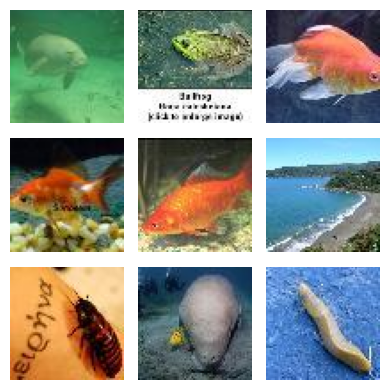

In [6]:
# Define a text query for image search
text_query: str = "fish"

# Test the search_images function
retrieved_images = search_images(pipeline, table, text_query, verbose=True)

# Visualize the retrieved images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(4, 4))  # Adjust figsize for better display
for ax, img in zip(axes.ravel(), retrieved_images):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

### Launch Gradio App

In [7]:
demo = generate_app(pipeline, table)

d:\Work\Academic\Online Courses\Generative AI (Udacity)\course5_building_generative_ai_solutions\projects\multimodal-search\app.py:27: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  ).style(columns=[3], rows=[3], object_fit="contain", height="auto")


Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://3d250e2a9e7fdac926.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3d250e2a9e7fdac926.gradio.live


In [8]:
demo.close()

Closing server running on port: 7860
